# <center>Домашняя работа по лекции 16
### Задание:
Опираясь на табличное обучение с подкреплением реализовать и обучить нейронную Q-функцию.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Copied from https://github.com/neilslater/game_playing_scripts

'''
   Copyright 2017 Neil Slater

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''

import numpy as np
import random

class TicTacToeGame():
    def __init__(self):
        self.state = '         '
        self.player = 'X'
        self.winner = None

    def allowed_moves(self):
        states = []
        for i in range(len(self.state)):
            if self.state[i] == ' ':
                states.append(self.state[:i] + self.player + self.state[i+1:])
        return states

    def make_move(self, next_state):  # или ход привел к чьей-то победе, или переход хода
        if self.winner:
            raise(Exception("Game already completed, cannot make another move!"))
        if not self.__valid_move(next_state):
            raise(Exception("Cannot make move {} to {} for player {}".format(
                    self.state, next_state, self.player)))

        self.state = next_state
        self.winner = self.predict_winner(self.state)
        if self.winner:
            self.player = None
        elif self.player == 'X':
            self.player = 'O'
        else:
            self.player = 'X'

    def playable(self):
        return ( (not self.winner) and any(self.allowed_moves()) )  # победителя еще нет и есть доступные ходы

    def predict_winner(self, state):
        lines = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]
        winner = None
        for line in lines:
            line_state = state[line[0]] + state[line[1]] + state[line[2]]
            if line_state == 'XXX':
                winner = 'X'
            elif line_state == 'OOO':
                winner = 'O'
        return winner

    def __valid_move(self, next_state):
        allowed_moves = self.allowed_moves()
        if any(state == next_state for state in allowed_moves):
            return True
        return False

    def print_board(self):
        s = self.state
        print('     {} | {} | {} '.format(s[0],s[1],s[2]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[3],s[4],s[5]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[6],s[7],s[8]))


In [57]:
class Agent():
    def __init__(self, game_class, model, criterion, epsilon=0.1, 
                 lr=0.001, gamma=1.0, q_delta=0.02, player_mark='X', epoch_size=1000, batch_size=100):
        self.Q = model.to(device)
        self.NewGame = game_class
        self.epsilon = epsilon
        self.criterion = criterion
        self.optimizer = torch.optim.Adadelta(self.Q.parameters())
        self.player_mark = player_mark
        self.gamma = gamma
        self.q_delta = q_delta
        self.next_Q_func = torch.FloatTensor([0]).view(1, 1).requires_grad_(True).to(device)
        self.losses = []
        self.total_episode = 0
        self.history = None
        self.batches = None
        self.epoch_size = epoch_size
        self.batch_size = batch_size
        
        self.history_reset()

    def history_reset(self):
        self.history = {'state': [], 'move': [], 'reward': [], 'next_state': [], 'next_move': []}
    
    @staticmethod
    def stateact_totensor(state, move):
        sign_to_value = {"X": 1.0, "O": -1.0, " ": 0.0}
        tensor = torch.FloatTensor([sign_to_value[item] for item in state + move]).requires_grad_(True).view(1, len(state + move)).to(device)
        return tensor

    def Q_func(self, game_state, move, Q_freezed=None):
        Q = Q_freezed or self.Q
        if move:
            Q_func = Q(self.stateact_totensor(game_state, move))
        else:
            Q_func = torch.FloatTensor([0.]).requires_grad_(True).view(1, 1).to(device)
        return Q_func

    def learn_game(self, num_episodes=1000, reset=False):
        if reset:
            self.total_episode = 0
            self.history_reset()
        for episode in range(num_episodes):
            self.learn_from_episode()
            self.total_episode += 1

    def learn_from_episode(self):
        game = self.NewGame()
        _, move = self.learn_select_move(game.state, game)  # выбираем начальный ход (учитываем заданное правило)
        r = self.__reward(game)
        while move:
            move = self.learn_from_move(game, move)
        if self.total_episode % self.epoch_size == 0 and self.total_episode > 0:
#             raise(ValueError)
            self.process_learning()
            self.history_reset()
    
    def _batching(self):
        self.batches = []
        batch = []
        for i in range(len(self.history['move'])):
            state = self.history['state'][i]
            best_move = self.history['move'][i]
            r = self.history['reward'][i]
            next_state = self.history['next_state'][i]
            next_best_move = self.history['next_move'][i]
            batch.append([state, best_move, r, next_state, next_best_move])
            if (i + 1) % self.batch_size == 0:
                self.batches.append(batch)
                batch = []
        return self.batches
            
    def process_learning(self):
        """update policy table based on latest game"""
        self._batching()
#         raise(ValueError)

        Q_freezed = copy.deepcopy(self.Q).requires_grad_(False)
        for batch in self.batches:
            loss = 0
            for state, best_move, r, next_state, next_best_move in batch:
                current_Q = self.Q_func(state, best_move)
                next_Q = self.Q_func(next_state, next_best_move, Q_freezed)

                td_target = r + self.gamma * next_Q
                loss += self.criterion(current_Q, td_target)

            loss /= len(batch)
            # обучаем сеть
            self.Q.zero_grad()
            self.losses.append(loss.data.item())
            loss.backward()
            # делаем шаг в сторону улучшения модели
            self.optimizer.step()

#     @staticmethod
#     def digit_to_target(digit):
#         return torch.FloatTensor([digit]).view(1, 1).requires_grad_(True).to(device)
    
    def learn_from_move(self, game, move):
        self.history['state'].append(game.state)
        self.history['move'].append(move)
        game.make_move(move)  # проверяет, есть ли победитель в game.winner, и если нет - переход хода
        r = self.__reward(game)  # вычисляем вознаграждение за ход move
        next_Q_func = 0.0
        selected_next_move = None
        if game.playable():  # победителя еще нет и есть доступные ходы
            best_next_move, selected_next_move = self.learn_select_move(move, game)  
            
#         self.history['states'].append(move)
        self.history['reward'].append(r)
        self.history['next_state'].append(game.state)
        self.history['next_move'].append(selected_next_move) 

        return selected_next_move

    def learn_select_move(self, current_state, game):
        allowed_move_Q_func = self.__Q_func(current_state, game.allowed_moves())  # словарь состояние-значение
        if game.player == self.player_mark:
            best_move = self.__argmax_Q(allowed_move_Q_func)
        else:
            best_move = self.__argmin_Q(allowed_move_Q_func)

        selected_move = best_move
        if random.random() < self.epsilon:   # добавляем случайный ход (здесь - в 10%, согласно epsilon)
            selected_move = self.__random_Q(allowed_move_Q_func)

        return (best_move, selected_move)

    def play_select_move(self, move, game):
        allowed_state_values = self.__Q_func(move, game.allowed_moves())  # словарь с доступными ходами и их values
        if game.player == self.player_mark:
            return self.__argmax_Q(allowed_state_values)  # выбираем наулучших ход для player_mark
        else:
            # ходит "не player_mark": выбираем наулучших ход для "не player_mark" (== наихудший для player_mark)
            return self.__argmin_Q(allowed_state_values)  
    
    def demo_game(self, verbose=False):
        game = self.NewGame()
        t = 0
        move = game.state
        while game.playable():  # пока нет победителя и есть доступные ходы
            if verbose:
                print(" \nTurn {}\n".format(t))
                game.print_board()
            move = self.play_select_move(move, game)
            game.make_move(move)  # или ход привел к чьей-то победе, или переход хода
            t += 1
        if verbose:
            print(" \nTurn {}\n".format(t))
            game.print_board()
        if game.winner:
            if verbose:
                print("\n{} is the winner!".format(game.winner))
            return game.winner
        else:
            if verbose:
                print("\nIt's a draw!")
            return '-'

    def interactive_game(self, agent_player='X'):
        game = self.NewGame()
        t = 0
        move = game.state
        while game.playable():
            print(" \nTurn {}\n".format(t))
            game.print_board()
            if game.player == agent_player:
                move = self.play_select_move(move, game)  # делаем ход (выбранное новое состояние)
                game.make_move(move)
            else:
                move = self.__request_human_move(game)
                game.make_move(move)
            t += 1

        print(" \nTurn {}\n".format(t))
        game.print_board()

        if game.winner:
            print("\n{} is the winner!".format(game.winner))
            return game.winner
        print("\nIt's a draw!")
        return '-'

    def __Q_func(self, current_state, game_moves):
        return dict((move, self.Q_func(current_state, move)) for move in game_moves)

    def __argmax_Q(self, allowed_move_Q_func):
        max_Q = max(allowed_move_Q_func.values())
        chosen_state = random.choice([move for move, q in allowed_move_Q_func.items() if q >= max_Q - self.q_delta])
        return chosen_state

    def __argmin_Q(self, allowed_move_Q_func):
        min_Q = min(allowed_move_Q_func.values())
        chosen_state = random.choice([move for move, q in allowed_move_Q_func.items() if q <= min_Q + self.q_delta])
        return chosen_state

    def __random_Q(self, allowed_move_Q_func):
        return random.choice(list(allowed_move_Q_func.keys()))

    def __reward(self, game):
        if game.winner == self.player_mark:
            return 1.0
        elif game.winner:
            return -1.0
        else:
            return 0.0

    def __request_human_move(self, game):
        allowed_moves = [i+1 for i in range(9) if game.state[i] == ' ']
        human_move = None
        while not human_move:
            idx = int(input('Choose move for {}, from {} : '.format(game.player, allowed_moves)))
            if any([i==idx for i in allowed_moves]):
                human_move = game.state[:idx-1] + game.player + game.state[idx:]
        return human_move

In [7]:
class QModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9*2, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [6]:
def demo_game_stats(agent):
    games_num = 1000
    results = [agent.demo_game() for i in range(games_num)]
    game_stats = {k: round(results.count(k) / games_num * 100, 1) for k in ['X', 'O', '-']}
    print("    percentage results: {}".format(game_stats))

In [63]:
%%time

agent = Agent(TicTacToeGame, model=QModel(), criterion=nn.MSELoss(), epsilon=0.3, q_delta=0.02, gamma=1.0)
total_episodes = 0
print("Before learning:")
demo_game_stats(agent)

num_episodes = 5_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

Before learning:
    percentage results: {'X': 57.9, 'O': 30.2, '-': 11.9}
After 5000 learning games:
    percentage results: {'X': 46.6, 'O': 34.4, '-': 19.0}
Wall time: 1min 31s


In [69]:
num_episodes = 5_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 10000 learning games:
    percentage results: {'X': 49.8, 'O': 0.0, '-': 50.2}


In [73]:
num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 20000 learning games:
    percentage results: {'X': 0.0, 'O': 0.0, '-': 100.0}


## Loss function

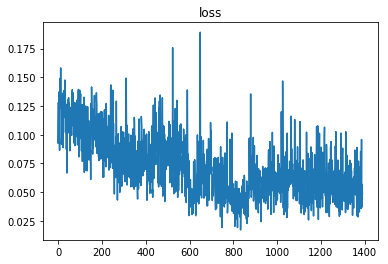

In [74]:
plt.plot(agent.losses)
plt.title("loss");

## Посмотрим, как обучился первый ход для **X**

In [75]:
for i in range(9):
    init_state = ' ' * 9
    move = [' '] * 9
    move[i] = 'X'
    move = ''.join(move)
    print(i + 1, move, round(agent.Q_func(init_state, move).item(), 4))

1 X         0.5403
2  X        0.4254
3   X       0.5358
4    X      0.3738
5     X     0.6729
6      X    0.3373
7       X   0.4191
8        X  0.3264
9         X 0.5054


**Резюме:** первый ход обучился правильно (по центру, см. 5 строку)

## Посмотрим, как обучился первый ход для **О**

In [76]:
for i in range(9):
    if i + 1 == 5:
        continue
    state = [' '] * 9
    state[4] = 'X'
    move = state.copy()
    move[i] = 'O'
    move = ''.join(move)
    state = ''.join(state)
    print(i + 1, move, round(agent.Q_func(state, move).item(), 4))

1 O   X     0.6993
2  O  X     0.7388
3   O X     0.6805
4    OX     0.8577
6     XO    0.9192
7     X O   0.7152
8     X  O  0.7531
9     X   O 0.6299


**Резюме:** первый ход для **О** обучился правильно (в угол, см. строку 9). кроме того, все угловые ходы имеют более высокий приоритет (с учетом того, что для **О** мы вибираем по минимуму), что как раз оптимальнее.

## Посмотрим Value для некторых комбинаций и сравним с тем, что должно быть

#### посмотрим батч, чтобы взять взять выигрышные, проигрышные и ничейные комбинации для проверок

In [77]:
agent.batches[0]

[['         ', '   X     ', 0.0, '   X     ', '   X   O '],
 ['   X     ', '   X   O ', 0.0, '   X   O ', '   XX  O '],
 ['   X   O ', '   XX  O ', 0.0, '   XX  O ', '   XX  OO'],
 ['   XX  O ', '   XX  OO', 0.0, '   XX  OO', '   XXX OO'],
 ['   XX  OO', '   XXX OO', 1.0, '   XXX OO', None],
 ['         ', '    X    ', 0.0, '    X    ', '    X   O'],
 ['    X    ', '    X   O', 0.0, '    X   O', '    XX  O'],
 ['    X   O', '    XX  O', 0.0, '    XX  O', '   OXX  O'],
 ['    XX  O', '   OXX  O', 0.0, '   OXX  O', '   OXXX O'],
 ['   OXX  O', '   OXXX O', 0.0, '   OXXX O', ' O OXXX O'],
 ['   OXXX O', ' O OXXX O', 0.0, ' O OXXX O', ' OXOXXX O'],
 [' O OXXX O', ' OXOXXX O', 1.0, ' OXOXXX O', None],
 ['         ', '    X    ', 0.0, '    X    ', '    XO   '],
 ['    X    ', '    XO   ', 0.0, '    XO   ', '    XO  X'],
 ['    XO   ', '    XO  X', 0.0, '    XO  X', 'O   XO  X'],
 ['    XO  X', 'O   XO  X', 0.0, 'O   XO  X', 'O   XOX X'],
 ['O   XO  X', 'O   XOX X', 0.0, 'O   XOX X', 'O O XOX

In [87]:
for item in agent.batches[0]:
    if item[4] is None:
        with torch.no_grad():
            print("reward / calculated reward by Q_func:\t", item[2], "/", round(agent.Q_func(item[0], item[1]).item(), 4))

reward / calculated reward by Q_func:	 1.0 / 0.6051
reward / calculated reward by Q_func:	 1.0 / 0.8974
reward / calculated reward by Q_func:	 1.0 / 0.8817
reward / calculated reward by Q_func:	 0.0 / -0.0954
reward / calculated reward by Q_func:	 0.0 / 0.0234
reward / calculated reward by Q_func:	 0.0 / 0.0593
reward / calculated reward by Q_func:	 -1.0 / -0.9823
reward / calculated reward by Q_func:	 1.0 / 0.8589
reward / calculated reward by Q_func:	 0.0 / 0.0168
reward / calculated reward by Q_func:	 0.0 / 0.0168
reward / calculated reward by Q_func:	 0.0 / 0.0593
reward / calculated reward by Q_func:	 1.0 / 0.9273


**Резюме:** **все** выигрыши, проигрыши и ничьи определены **верно**.

## demo game

In [83]:
agent.demo_game(True)

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 2

       |   |   
    -----------
       | X |   
    -----------
       |   | O 
 
Turn 3

       |   |   
    -----------
       | X | X 
    -----------
       |   | O 
 
Turn 4

       |   |   
    -----------
     O | X | X 
    -----------
       |   | O 
 
Turn 5

       |   |   
    -----------
     O | X | X 
    -----------
     X |   | O 
 
Turn 6

       |   | O 
    -----------
     O | X | X 
    -----------
     X |   | O 
 
Turn 7

       |   | O 
    -----------
     O | X | X 
    -----------
     X | X | O 
 
Turn 8

       | O | O 
    -----------
     O | X | X 
    -----------
     X | X | O 
 
Turn 9

     X | O | O 
    -----------
     O | X | X 
    -----------
     X | X | O 

It's a draw!


'-'

## Несколько игр с агентом вручную для проверки стандартных комбинаций

In [84]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  1


 
Turn 2

     O |   |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 3

     O |   |   
    -----------
     X | X |   
    -----------
       |   |   


Choose move for O, from [2, 3, 6, 7, 8, 9] :  6


 
Turn 4

     O |   |   
    -----------
     X | X | O 
    -----------
       |   |   
 
Turn 5

     O | X |   
    -----------
     X | X | O 
    -----------
       |   |   


Choose move for O, from [3, 7, 8, 9] :  8


 
Turn 6

     O | X |   
    -----------
     X | X | O 
    -----------
       | O |   
 
Turn 7

     O | X |   
    -----------
     X | X | O 
    -----------
     X | O |   


Choose move for O, from [3, 9] :  3


 
Turn 8

     O | X | O 
    -----------
     X | X | O 
    -----------
     X | O |   
 
Turn 9

     O | X | O 
    -----------
     X | X | O 
    -----------
     X | O | X 

It's a draw!


'-'

In [85]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  2


 
Turn 2

       | O |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 3

       | O |   
    -----------
       | X |   
    -----------
       |   | X 


Choose move for O, from [1, 3, 4, 6, 7, 8] :  1


 
Turn 4

     O | O |   
    -----------
       | X |   
    -----------
       |   | X 
 
Turn 5

     O | O | X 
    -----------
       | X |   
    -----------
       |   | X 


Choose move for O, from [4, 6, 7, 8] :  7


 
Turn 6

     O | O | X 
    -----------
       | X |   
    -----------
     O |   | X 
 
Turn 7

     O | O | X 
    -----------
       | X | X 
    -----------
     O |   | X 

X is the winner!


'X'

In [86]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  8


 
Turn 2

       |   |   
    -----------
       | X |   
    -----------
       | O |   
 
Turn 3

       |   |   
    -----------
       | X |   
    -----------
       | O | X 


Choose move for O, from [1, 2, 3, 4, 6, 7] :  1


 
Turn 4

     O |   |   
    -----------
       | X |   
    -----------
       | O | X 
 
Turn 5

     O |   | X 
    -----------
       | X |   
    -----------
       | O | X 


Choose move for O, from [2, 4, 6, 7] :  6


 
Turn 6

     O |   | X 
    -----------
       | X | O 
    -----------
       | O | X 
 
Turn 7

     O |   | X 
    -----------
       | X | O 
    -----------
     X | O | X 

X is the winner!


'X'

#### Вывод:
Агент явно обучился. Об этом говорит следующее:
- расчет обученным агентом значения **Q_func** для **первого хода Х** - оптимальный уверенно по центру
- **первый ход O** тоже обучился правильно. Более того, **все** оптимальные первые ходы нолика (угловые) тоже более приоритетны по Q_func (с учетом того, что для ноликов мы выбираем по минимуму).
- выборочные проверки вычисления значений **Q_func** некоторых **заранее известных** состояний  (выигрышей, проигрышей и ничьих) - все расчитано правильно. 
- а также несколько сыгранных с агентом игр. Агент играл каждый раз оптимально.   
- Лосс уменьшается в процессе обучения   
- Результат на демо: итоговый **percentage results: {'X': 0.0, 'O': 0.0, '-': 100.0}**. Динамика обучения по **percentage results** хорошо видна и наглядна.   
   
**Итого:** агент обучился правильно.